In [1]:
!pip install git+https://github.com/desi-bgs/bgs-cmxsv.git --upgrade --user

  Cloning https://github.com/desi-bgs/bgs-cmxsv.git to /tmp/pip-req-build-037e_1gk
  Running command git clone -q https://github.com/desi-bgs/bgs-cmxsv.git /tmp/pip-req-build-037e_1gk
  Created wheel for bgs-sv: filename=bgs_sv-0.0-py3-none-any.whl size=1087771 sha256=105fe2720af22f96a8e7fc2210806be7e6cb7e6622aaae17fe693f6a43e4bd3c
  Stored in directory: /tmp/pip-ephem-wheel-cache-z6845bqw/wheels/c5/7b/33/3fa8f7338087a37e7ad7a1378e08d97458e5dbab577a10268f
Successfully built bgs-sv
  Attempting uninstall: bgs-sv
    Found existing installation: bgs-sv 0.0
    Uninstalling bgs-sv-0.0:
      Successfully uninstalled bgs-sv-0.0


In [2]:
import numpy as np 
import astropy.table as atable
import matplotlib.pyplot as plt

from bgs_sv import sv1

# read single exposures from Blanc reduction with similar to nominal BGS conditions

In [3]:
exps = sv1.blanc_nexp1_exposures()

In [4]:
# lets only keep the nightly exposures where we have a corresponding 
# deep exposure that we can use as the truth table
deep_exp = sv1.blanc_deep_exposures()

keep = np.zeros(len(exps)).astype(bool)
for i in range(len(exps)): 
    if exps[i]['TILEID'] in deep_exp['TILEID']: 
        keep[i] = True
print('%i exposures with corresponding deep exposures' % np.sum(keep))

175 exposures with corresponding deep exposures


In [5]:
r_depth_ebvair = 180
d_r_depth_ebvair = 20
close_to_nominal = np.abs(exps['R_DEPTH_EBVAIR'] - r_depth_ebvair) < d_r_depth_ebvair
isbgs = (exps['TARGETS'] == 'BGS+MWS')

bgs_exps = exps[isbgs & keep & close_to_nominal]
print(bgs_exps['TILEID', 'NIGHT', 'EXPID'])
print('%i exposures that have deep and are close to nominal' % len(bgs_exps))

TILEID  NIGHT   EXPID
------ -------- -----
 80614 20201218 68686
 80616 20201219 68790
 80617 20201220 69024
 80617 20201220 69026
 80612 20201221 69223
 80613 20201221 69225
 80613 20201221 69227
 80613 20201221 69228
 80613 20201221 69230
9 exposures that have deep and are close to nominal


Now lets get sky surface brightness measurements for these exposures

In [6]:
# get sky surface brightnesses
Iskies = []
for i in np.arange(len(bgs_exps)):
    wave, Isky = sv1.get_obs_sky(int(bgs_exps[i]['NIGHT']), int(bgs_exps[i]['EXPID']), 'model', redux="daily");
    Iskies.append(Isky * 1e17)

In [7]:
# read in BGS reference sky brightness
f_reference = '/global/cfs/cdirs/desi/users/chahah/BGS_reference_sky_brightness.20210210.npy'
w_ref, Isky_ref = np.load(f_reference)

Text(0.5, 1.0, 'BGS ref. sky vs Blanc skies')

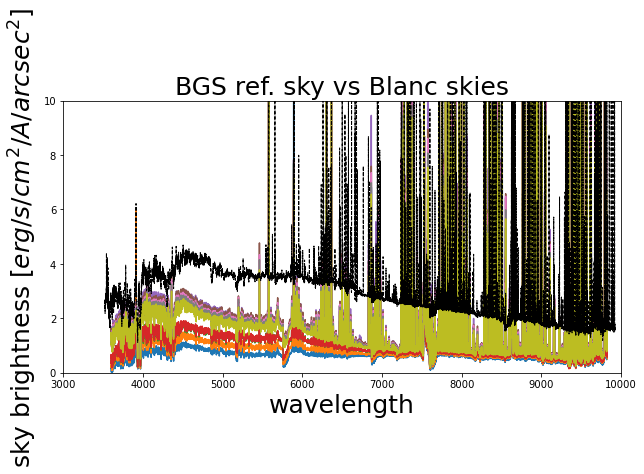

In [8]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)

for Isky in Iskies: 
    sub.plot(wave, Isky)

sub.plot(w_ref, Isky_ref, c='k', ls='--', lw=1, label='BGS reference sky')
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(3e3, 1e4)
sub.set_ylabel('sky brightness [$erg/s/cm^2/A/arcsec^2$]', fontsize=25)
sub.set_ylim(0., 10.)
sub.set_title('BGS ref. sky vs Blanc skies', fontsize=25)

Blanc BGS exposures with R_DEPTH_EBVAIR ~ 180, have darker skies than the reference BGS sky... 

# caclulate $z$ success rate for nexp=1 expsoures using the deep exposures as the truth table

In [9]:
def get_exp_zsuccess(tileid, night, expid): 
    ''' get redshift success rate for given exposure
    '''
    # get redrock output for DEEP exposure for BGS_ANY targets
    _zbest_deep = sv1.get_zbest(tileid, 'deep', targetclass='all')
    
    crit_zwarn = (_zbest_deep['ZWARN'] == 0)
    crit_dchi2 = (_zbest_deep['DELTACHI2']  > 40.) 
    crit_stype = (_zbest_deep['SPECTYPE'] != "STAR") # only galaxy spectra
    crit_z_lim = (_zbest_deep['Z'] > 0.0) & (_zbest_deep['Z'] < 0.6) # rough BGS redshift limit
    crit_z_err = (_zbest_deep['ZERR'] < (0.0005 * (1. + _zbest_deep['Z'])))
    
    truth_table = crit_dchi2 & crit_stype & crit_z_lim & crit_z_err
    zbest_deep = _zbest_deep[truth_table]['TARGETID', 'Z']
    # redrock redshifts from DEEP exposure will be used as true redshifts
    zbest_deep.rename_column('Z', 'Z_TRUE')
    
    # get redrock output for SINGLE exposure for BGS_ANY targets
    zbest_exp = sv1.get_zbest(tileid, night, expid=expid, targetclass='all')

    # only keep targets that are in the deep
    zbest_exp = atable.join(zbest_deep, zbest_exp, keys='TARGETID', join_type='inner')
    
    crit_zwarn = (zbest_exp['ZWARN'] == 0)
    crit_dchi2 = (zbest_exp['DELTACHI2']  > 40.) 
    crit_stype = (zbest_exp['SPECTYPE'] != "STAR") # only galaxy spectra
    crit_z_lim = (zbest_exp['Z'] > 0.0) & (zbest_exp['Z'] < 0.6) # rough BGS redshift limit
    crit_z_err = (zbest_exp['ZERR'] < (0.0005 * (1. + zbest_exp['Z'])))
    
    dz_1pz = np.abs(zbest_exp['Z_TRUE'] - zbest_exp['Z']) / (1. + zbest_exp['Z_TRUE'])
    crit_ztrue = (dz_1pz < 0.003)

    # combine all criteria
    zsuccess = crit_zwarn & crit_dchi2 & crit_stype & crit_z_lim & crit_z_err & crit_ztrue
    
    r_mag = 22.5 - 2.5 * np.log10(zbest_exp['FLUX_R']) 
    return r_mag, zsuccess

In [10]:
r_mags, zs_exps = [], [] 
for tid, n, eid in zip(bgs_exps['TILEID'], bgs_exps['NIGHT'], bgs_exps['EXPID']): 
    r_mag, zs_exp = get_exp_zsuccess(tid, n, eid)
    r_mags.append(r_mag)
    zs_exps.append(zs_exp)

In [11]:
# first lets install the python package `feasibgs`, a python package for the BGS spectral simulations
!pip install git+https://github.com/desi-bgs/feasiBGS.git --upgrade --user

  Cloning https://github.com/desi-bgs/feasiBGS.git to /tmp/pip-req-build-y9lckeql
  Running command git clone -q https://github.com/desi-bgs/feasiBGS.git /tmp/pip-req-build-y9lckeql
  Created wheel for feasibgs: filename=feasibgs-0.1-py3-none-any.whl size=47422 sha256=5f002cbbf25788cf1e19e33b38770b2a15e840715d1e243333fd51644db6108e
  Stored in directory: /tmp/pip-ephem-wheel-cache-f42ewzyk/wheels/f7/d7/9d/824c3b88b5bd8c28b8c576f20984e3cf31a80def7e3deae10a
Successfully built feasibgs
  Attempting uninstall: feasibgs
    Found existing installation: feasibgs 0.1
    Uninstalling feasibgs-0.1:
      Successfully uninstalled feasibgs-0.1


In [12]:
from feasibgs import spectral_sims as BGS_spec_sim
from feasibgs import util as UT
import fitsio

In [13]:
# read in source wavelength, flux, and galaxy properties. 
wave_s, flux_s, prop = BGS_spec_sim.simulated_GAMA_source_spectra(emlines=True)

# extract true redshift and r-band magnitude for the simulated galaxies
ztrue_sim = prop['zred'] # redshift
r_mag_sim = prop['r_mag'] # Legacy Survey r mag

# read redrock output
frr = '/global/cfs/cdirs/desi/users/chahah/redrock.bgs_spectral_sim.new_bgs_ref_sky.texp300s.fits' 
rr = fitsio.read(frr)

# redshift success defined as |z_redrock - z_true|/(1+z_true) < 0.003 and ZWARN flag = 0 
zs_ref = UT.zsuccess(rr['Z'], ztrue_sim, rr['ZWARN'], deltachi2=rr['DELTACHI2'], min_deltachi2=40)
#zs_ref[r_mag_sim < 18.2] = True # this is to account for the unusual bright z failures, which we think will eventually be ironed out

Text(0, 0.5, '$z$ success rate')

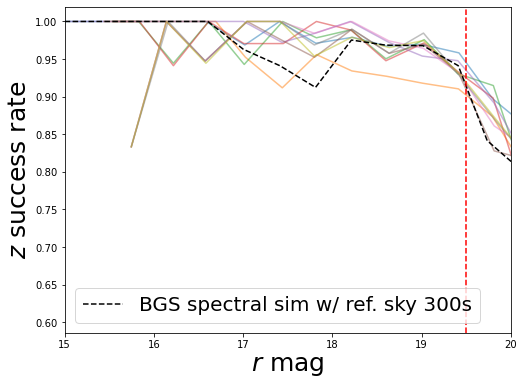

In [14]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

for r_mag, zs_exp in zip(r_mags, zs_exps):     
    r_mid, zs, zs_err = UT.zsuccess_rate(r_mag, zs_exp, range=(14, 22), nbins=20)
    sub.plot(r_mid, zs, alpha=0.5)
r_mid, zs, zs_err = UT.zsuccess_rate(r_mag_sim, zs_ref, range=(14, 22), nbins=20)
sub.plot(r_mid, zs, c='k', ls='--', label='BGS spectral sim w/ ref. sky 300s')
sub.legend(loc='lower left', fontsize=20)
sub.axvline(19.5, c='r', ls='--')
sub.set_xlabel('$r$ mag', fontsize=25)
sub.set_xlim(15, 20)
sub.set_ylabel('$z$ success rate', fontsize=25)

In [15]:
zs_19p5_ref = np.sum(zs_ref[r_mag_sim <= 19.5])/np.sum(r_mag_sim <= 19.5)
zs_19p5, zs_20p0 = [], []
for r_mag, zs_exp in zip(r_mags, zs_exps):
    zs_19p5.append(np.sum(zs_exp[r_mag <= 19.5])/np.sum(r_mag <= 19.5))
    zs_20p0.append(np.sum(zs_exp[r_mag <= 20.0])/np.sum(r_mag <= 20.0))

In [16]:
print('BGS spectral sim w/ reference')
print('redshift success rate r < 19.5 = %.3f' % zs_19p5_ref)
print('Blanc BGS exposures')
print('redshift success rate r < 19.5 = %.3f' % np.median(zs_19p5))
print('redshift success rate r < 20.0 = %.3f' % np.median(zs_20p0))

BGS spectral sim w/ reference
redshift success rate r < 19.5 = 0.964
Blanc BGS exposures
redshift success rate r < 19.5 = 0.967
redshift success rate r < 20.0 = 0.934


The spectral simulations are able to closely reproduce the SV1 exposures that are close to BGS. 